### Generating an undirected network with the defined statistics

In [1]:
import multiprocessing
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import optuna
import pandas as pd
from scipy.stats import ks_2samp
from tqdm.notebook import tqdm

In [2]:
stats = {
    "number_nodes": 1882,
    "radius": [15, 2],
    "diameter": [28, 4],
    "average_clustering": [0.005066798238955518, 0.001],
    "average_path_length": [11.748410823170731, 2],
    "number_cc": [168, 32],
    "degree_cdf": [
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 24, 46],
        [
            0.0,
            0.6902231668437833,
            0.8517534537725824,
            0.9086078639744952,
            0.9378320935175345,
            0.9516471838469713,
            0.9654622741764081,
            0.9723698193411264,
            0.9776833156216791,
            0.9808714133900106,
            0.9845908607863975,
            0.9888416578108395,
            0.9893730074388948,
            0.9925611052072264,
            0.9936238044633369,
            0.9952178533475027,
            0.9957492029755579,
            0.9968119022316685,
            0.997874601487779,
            0.9989373007438895,
            0.9994686503719448,
            1.0,
        ],
    ],
}

In [3]:
q_seq, p_seq = stats["degree_cdf"]
q_seq = np.array(q_seq)
p_seq = np.array(p_seq)

In [4]:
# get the true distribution of nodes degree in the graph
degrees_counts = p_seq[1:] * stats["number_nodes"] - p_seq[:-1] * stats["number_nodes"]
degrees_dist = []
for i in range(len(degrees_counts)):
    degrees_dist.extend([q_seq[i + 1]] * int(degrees_counts[i]))

In [5]:
def diff(a, b):
    """
    Get the difference between two dicts
    """
    b_ = defaultdict(int)
    for x in a:
        b_[x] += 1
    for x in b:
        b_[x] -= 1
    return {k: v for k, v in b_.items() if v > 0}

In [6]:
def gaussian_kernel(x, y, sigma):
    return np.exp(-((x - y) ** 2) / (2 * sigma ** 2))

In [7]:
def get_score(G):
    gcc = max(nx.connected_components(G), key=len)
    gcc = G.subgraph(gcc).copy()
    average_clustering = nx.average_clustering(G)
    average_shortest_path_length = nx.average_shortest_path_length(gcc)
    diameter = nx.diameter(gcc)
    radius = nx.radius(gcc)
    lenG = len([x for x in nx.connected_components(G)])
    ks_test = 1 - ks_2samp(degrees_dist, list(dict(G.degree()).values())).statistic

    r = {
        "average_clustering": gaussian_kernel(
            average_clustering, *stats["average_clustering"]
        ),
        "average_shortest_path_length": gaussian_kernel(
            average_shortest_path_length, *stats["average_path_length"]
        ),
        "diameter": gaussian_kernel(diameter, *stats["diameter"]),
        "radius": gaussian_kernel(radius, *stats["radius"]),
        "lenG": gaussian_kernel(lenG, *stats["number_cc"]),
        "ks_test": ks_test,
    }
    r["sum"] = 100 * sum(list(r.values())) / 6
    if len(G) != 1882 or (0 in dict(G.degree).values()):
        r["sum"] = 0
    return r

#### First, fit the best GCC with defined average_shortest_path_length, diameter and radius

In [8]:
def objective(trial):
    params = {
        "n": trial.suggest_int("n", 200, 400),
        "k": trial.suggest_int("k", 2, 6),
        "p": trial.suggest_float("p", 0.1, 0.9),
        "seed": trial.suggest_int("seed", 1_000_000, 5_000_000),
    }
    G = nx.watts_strogatz_graph(**params)
    gcc = max(nx.connected_components(G), key=len)
    gcc = G.subgraph(gcc).copy()
    average_shortest_path_length = nx.average_shortest_path_length(gcc)
    diameter = nx.diameter(gcc)
    radius = nx.radius(gcc)
    return np.array(
        [
            gaussian_kernel(
                average_shortest_path_length, *stats["average_path_length"]
            ),
            gaussian_kernel(diameter, *stats["diameter"]),
            gaussian_kernel(radius, *stats["radius"]),
        ]
    ).mean()

In [9]:
# storage = optuna.storages.RDBStorage('sqlite:///watts_strogatz_graph.db')
# study = optuna.create_study(storage=storage, sampler=optuna.samplers.TPESampler(seed=42),
#                             study_name='watts_strogatz_graph.2', direction='maximize', load_if_exists=True)
# study.optimize(objective, n_trials=5000)

In [10]:
# params = study.best_params
params = {"k": 2, "n": 248, "p": 0.6564426354975202, "seed": 3358684}
params

{'k': 2, 'n': 248, 'p': 0.6564426354975202, 'seed': 3358684}

In [11]:
G = nx.watts_strogatz_graph(**params)
gcc = max(nx.connected_components(G), key=len)
gcc = G.subgraph(gcc).copy()

In [12]:
get_score(G)

{'average_clustering': 0.2548069247699286,
 'average_shortest_path_length': 0.9999629597005202,
 'diameter': 0.9692332344763441,
 'ks_test': 0.6847768331562167,
 'lenG': 1.6854852873722927e-06,
 'radius': 1.0,
 'sum': 0}

In [13]:
len(gcc)

129

In [14]:
# no nodes with unnecessary degrees
diff(list(dict(gcc.degree()).values()), degrees_dist)

{}

#### Second, add all the requiered nodes with defined degrees (but the adding components should be less than gcc computed ealier)

In [15]:
# need to add those nodes to gcc
degrees_add = diff(degrees_dist, list(dict(gcc.degree()).values()))
degrees_add

{1: 1249,
 2: 263,
 3: 80,
 4: 45,
 5: 25,
 6: 26,
 7: 13,
 8: 10,
 9: 6,
 10: 7,
 11: 8,
 12: 1,
 13: 6,
 14: 2,
 15: 3,
 16: 1,
 17: 2,
 19: 2,
 21: 2,
 24: 1,
 46: 1}

In [16]:
# form random sequence of degree distribution
np.random.seed(42)

degrees_dist_add = []
for k, v in degrees_add.items():
    degrees_dist_add.extend([k] * v)
degrees_dist_add = np.random.permutation(degrees_dist_add)

In [17]:
degrees_dist_add.shape[0] + len(gcc)

1882

In [18]:
# algorithm of adding several componets to the graph (but less than gcc)
additional_graphs = [gcc]
graphs_configurations = []
graphs_configuration = [degrees_dist_add[0]]
G_add = None
for add in degrees_dist_add[1:]:
    if not sum(graphs_configuration) % 2:
        G_tmp = nx.configuration_model(graphs_configuration, seed=42)
        G_tmp = nx.Graph(G_tmp)
        G_tmp.remove_edges_from(nx.selfloop_edges(G_tmp))
        if len(max(nx.connected_components(G_tmp), key=len)) < len(gcc):
            G_add = G_tmp.copy()
            valid_configuration = graphs_configuration.copy()
        else:
            G_add.remove_edges_from(nx.selfloop_edges(G_add))
            G_add = nx.relabel_nodes(
                G_add, lambda x: x + 100000 * len(additional_graphs)
            )
            additional_graphs.append(G_add.copy())
            G_add = None
            graphs_configurations.append(valid_configuration)
            graphs_configuration_new = []
            graphs_configuration_new.extend(
                graphs_configuration[len(valid_configuration) :]
            )
            graphs_configuration = graphs_configuration_new.copy()
    graphs_configuration.append(add)

G_add = nx.configuration_model(graphs_configuration, seed=42)
G_add = nx.Graph(G_add)
G_add.remove_edges_from(nx.selfloop_edges(G_add))
G_add = nx.relabel_nodes(G_add, lambda x: x + 100000 * len(additional_graphs))
additional_graphs.append(G_add)
graphs_configurations.append(graphs_configuration)

In [19]:
len(graphs_configurations)

9

In [20]:
assert np.sum(degrees_dist_add) == np.sum(
    [np.sum(graphs_configuration) for graphs_configuration in graphs_configurations]
)

In [21]:
sum([len(x) for x in additional_graphs])

1882

In [22]:
G_final = nx.compose_all(additional_graphs)

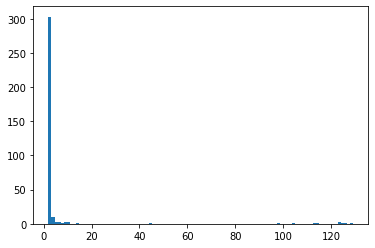

In [23]:
# there are a lot of little components
plt.hist([len(x) for x in nx.connected_components(G_final)], bins=100);

In [24]:
len(G_final)

1882

In [25]:
nx.number_of_selfloops(G_final)

0

In [26]:
len(
    set(np.array(list(G_final.edges()))[:, 1])
    | set(np.array(list(G_final.edges()))[:, 0])
)

1882

In [27]:
# check for not connected nodes
set(G_final.nodes()) - (
    set(np.array(list(G_final.edges()))[:, 1])
    | set(np.array(list(G_final.edges()))[:, 0])
)

set()

In [28]:
# in case the previous set is not empty - need to add a connection to that nodes
# G_final.add_edge(300088, 900050)

In [29]:
get_score(G_final)

{'average_clustering': 0.061034084642388436,
 'average_shortest_path_length': 0.9999629597005202,
 'diameter': 0.9692332344763441,
 'ks_test': 0.9946865037194474,
 'lenG': 1.2187610094869082e-06,
 'radius': 1.0,
 'sum': 67.08196668832848}

#### Third, fit the number of connected components

There is no algorithm for this (non-automated) - in order not to spoil the distribution (ks-test)

In [30]:
diff(degrees_dist, list(dict(G_final.degree()).values()))

{4: 3,
 6: 1,
 7: 1,
 8: 3,
 11: 2,
 13: 3,
 15: 1,
 17: 2,
 19: 2,
 21: 1,
 24: 1,
 46: 1}

In [31]:
base_node46 = [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][0][0]
base_node24 = [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][0][1]
G_final.remove_edge(base_node46, base_node24)

for node_pair in [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][
    :23
]:
    G_final.remove_edge(*node_pair)
    G_final.add_edge(base_node46, node_pair[0])
    G_final.add_edge(base_node46, node_pair[1])

for node_pair in [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][
    :12
]:
    G_final.remove_edge(*node_pair)
    G_final.add_edge(base_node24, node_pair[0])
    G_final.add_edge(base_node24, node_pair[1])

In [32]:
base_node = [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][0][0]

for node_pair in [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][
    1:60
]:
    G_final.remove_edge(*node_pair)
    G_final.add_edge(base_node, node_pair[0])
    G_final.add_edge(base_node, node_pair[1])

In [33]:
base_node = [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][0][0]

for node_pair in [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][
    1:50
]:
    G_final.remove_edge(*node_pair)
    G_final.add_edge(base_node, node_pair[0])
    G_final.add_edge(base_node, node_pair[1])

In [34]:
base_node1 = [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][0][0]
base_node2 = [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][0][1]

for node_pair in [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][
    :10
]:
    G_final.remove_edge(*node_pair)
    G_final.add_edge(base_node1, node_pair[0])
    G_final.add_edge(base_node1, node_pair[1])

In [35]:
for node_pair in [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][
    :9
]:
    G_final.remove_edge(*node_pair)
    G_final.add_edge(base_node2, node_pair[0])
    G_final.add_edge(base_node2, node_pair[1])

In [36]:
base_node = [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][0][0]

for node_pair in [sorted(x) for x in nx.connected_components(G_final) if len(x) == 2][
    1:8
]:
    G_final.remove_edge(*node_pair)
    G_final.add_edge(base_node, node_pair[0])
    G_final.add_edge(base_node, node_pair[1])

In [37]:
diff(degrees_dist, list(dict(G_final.degree()).values()))

{1: 4, 4: 3, 6: 1, 7: 1, 8: 3, 11: 2, 13: 3, 17: 2, 19: 1}

In [38]:
diff(list(dict(G_final.degree()).values()), degrees_dist)

{3: 4, 5: 6, 10: 2, 12: 2, 16: 2, 18: 1, 35: 1, 99: 1, 119: 1}

In [39]:
get_score(G_final)

{'average_clustering': 0.061034084642388436,
 'average_shortest_path_length': 0.9999629597005202,
 'diameter': 0.9692332344763441,
 'ks_test': 0.997874601487779,
 'lenG': 1.0,
 'radius': 1.0,
 'sum': 83.80174800511719}

In [40]:
G_final.remove_edges_from(nx.selfloop_edges(G_final))

In [41]:
len(G_final)

1882

In [42]:
set(G_final.nodes()) - (
    set(np.array(list(G_final.edges()))[:, 1])
    | set(np.array(list(G_final.edges()))[:, 0])
)

set()

In [43]:
len(
    set(np.array(list(G_final.edges()))[:, 1])
    | set(np.array(list(G_final.edges()))[:, 0])
)

1882

#### Fourth, prepare average clustering

In [44]:
base_g = G_final.copy()

In [45]:
def task(pack):
    """
    add-del task
    """
    action, a, b = pack
    g = base_g.copy()
    if action == "del":
        g.remove_edge(a, b)
    if action == "add":
        g.add_edge(a, b)
    g = g.copy()
    return {"action": action, "a": a, "b": b, **get_score(g)}

In [46]:
task2(("del", 1, 42))

{'a': 1,
 'action': 'del',
 'average_clustering': 0.061034084642388436,
 'average_shortest_path_length': 0.9999596229832033,
 'b': 42,
 'diameter': 0.9692332344763441,
 'ks_test': 0.997874601487779,
 'lenG': 0.9995118379398894,
 'radius': 1.0,
 'sum': 0}

In [47]:
if __name__ == "__main__":
    it = 0
    for it in range(it, 16):
        rnd = np.random.default_rng(202202242 + it)
        tasks = []

        base_score = get_score(base_g)
        assert base_score["sum"] > 0

        e = base_g.edges
        for r, (a, b) in zip(rnd.random(len(e)), e):
            if r < 1:
                tasks.append(("del", a, b))
        for a, b in rnd.integers(0, 1882, (len(tasks), 2)):
            if a != b and not base_g.has_edge(a, b):
                tasks.append(("add", a, b))
        r = []
        with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
            for x in tqdm(
                pool.imap_unordered(task, tasks, chunksize=1), total=len(tasks)
            ):
                r.append(x)

        df = pd.DataFrame(r).sort_values("sum", ascending=False)
        df.to_csv(f"iteration_{it}.csv")
        df = df[df["sum"] > base_score["sum"]]
        if len(df) == 0:
            print("Do nothing")
        else:
            row = df.iloc[0]
            g = base_g.copy()
            action, a, b = row["action"], row["a"], row["b"]
            if action == "del":
                g.remove_edge(a, b)
            if action == "add":
                g.add_edge(a, b)

            nx.write_edgelist(g, f"iteration_{it}.txt", data=False)

            base_g = g.copy()

In [48]:
# get the best iteration
g = nx.read_edgelist("iteration_5.txt")

In [49]:
len(g)

1882

In [50]:
get_score(g)

{'average_clustering': 0.9999661855570076,
 'average_shortest_path_length': 0.9999629597005202,
 'diameter': 0.9692332344763441,
 'ks_test': 0.9984059511158342,
 'lenG': 0.9995118379398894,
 'radius': 1.0,
 'sum': 99.45133614649325}

In [51]:
len([1 for _ in nx.connected_components(g)])

169

In [52]:
# connect two components
base_node0 = [sorted(x) for x in nx.connected_components(g) if len(x) == 47][0][0]
base_node1 = [sorted(x) for x in nx.connected_components(g) if len(x) == 38][0][0]

g.add_edge(base_node0, base_node1)

In [53]:
get_score(g)

{'average_clustering': 0.9999661855570076,
 'average_shortest_path_length': 0.9999629597005202,
 'diameter': 0.9692332344763441,
 'ks_test': 0.9984059511158342,
 'lenG': 1.0,
 'radius': 1.0,
 'sum': 99.45947218082843}

In [54]:
nx.write_edgelist(g, f"generation_algo.txt", data=False)